In [1]:
# IMPORT BLOCK
import networkx as nx 
import matplotlib.pyplot as plt 
import numpy as np
import EoN

In [2]:
# GENERIC CODE BLOCK (WILL APPEAR IN ALL NOTEBOOKS)
def run_until_time(G, xmission, recovery, rho, tmax, copy_graph=True):
    """ Runs a basic SIR (cont time) model on graph G 
        with fixed transmission/recovery_rate.
    ARGS:
        G: Networkx graph object
        xmission: float - transmission rate 
        recovery: float - recovery rate 
        rho:  float - fraction of nodes which are randomly 
                initially infected 
        tmax : float - time we run until 
    RETURNS:
        G': networx graph with all IR nodes/edges removed 
        summary: Infection_Summary object which summarizes the run 
                 *** ATTACHES THE .tmax attribute to this object ***
    """
    summary = EoN.fast_SIR(G, xmission, recovery, rho=rho, tmax=tmax, return_full_data=True)
    setattr(summary, 'tmax', tmax)
    # Now collect only the infected/recovered nodes 
    status_dict = _split_summary(summary)
    if copy_graph: 
        G = G.copy()
    if tmax > 0.0:
        G.remove_nodes_from(status_dict.get('I', []))
        G.remove_nodes_from(status_dict.get('R', []))
    
    return G, summary


def _split_summary(summary_obj):
    sort_dict = {} 
    for k, v in summary_obj.get_statuses(time=summary_obj.tmax).items():
        sort_dict[v] = sort_dict.get(v, [])
        sort_dict[v].append(k)
    return sort_dict 


def _cat_summaries(summary_list):
    # Returns, T, S, I, R of multiple runs stacked against each other 
    if not isinstance(summary_list, list):
        summary_list = [summary_list]
    t_lists, s_lists, i_lists, r_lists = [], [], [], [] 
    running_t = 0
    running_r = 0
    for summary in summary_list:
        # Save in-run data
        t_lists.append(running_t + summary.t())
        s_lists.append(summary.S())
        i_lists.append(summary.I())
        r_lists.append(running_r + summary.R())
        
        # add end-time-arrays 
        t_lists.append(np.array([summary.tmax + running_t]))
        s_lists.append(np.array([summary.S()[-1]]))
        i_lists.append(np.array([summary.I()[-1]]))
        r_lists.append(np.array([summary.R()[-1] + running_r]))
        
        # update running_r, running_t 
        running_t += summary.tmax
        running_r += summary.I()[-1] + summary.R()[-1]
        
    # And concatenate everything in the end 
    final_t = np.concatenate(t_lists)
    final_s = np.concatenate(s_lists)
    final_i = np.concatenate(i_lists)
    final_r = np.concatenate(r_lists)
    
    return final_t, final_s, final_i, final_r
        
        
def plot_sir_counts(summary_list, plot_series=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,8))
    t, s, i, r = _cat_summaries(summary_list)
    plot_series = plot_series or ['S', 'I', 'R']
    plot_reader = {'S': (s, 'susceptible'),
                   'I': (i, 'infected'), 
                   'R': (r, 'recovered')}
    for series in plot_series:
        data, label = plot_reader[series]
        ax.plot(t, data, label=label)
    ax.legend()
        

def quarantine_cycle(G, tau, gamma, rho, quarantine_times, total_time):
    # quarantine_times is the total times for when quarantines occur 
    # return is the same as the return of _cat_summaries
    if isinstance(quarantine_times, (int, float)):
        quarantine_times = [quarantine_times]
    run_times = [quarantine_times[0]] 
    intervals = quarantine_times + [total_time]
    for i in range(len(intervals) - 1):
        run_times.append(intervals[i+1] - intervals[i])
    print('running qs on series', run_times)
    summary_outs = []
    G = G.copy() 
    for run in run_times:
        G, summary = run_until_time(G, tau, gamma, rho=rho, tmax=run)
        summary_outs.append(summary)
    return _cat_summaries(summary_outs)
    
def selector(els, idxs):
    for idx in idxs:
        yield els[idx]
        
def tuple_filter(tup_iter, idx):
    return [tup[idx] for tup in tup_iter]

        
def c(i):
    return 'bgrcmyk'[i]


# THINGS TO PLOT 
# X-axis: timestep quarantine was performed at 
# Y-axis1: maximum number of infected at any one time 
# Y-axis2: number of recovered at t=infinity (so number of people who got it )

def get_max_I(catsum):
    return max(catsum[2])

def get_final_R(catsum):
    return catsum[3][-1]

def plot_single_qs(qrange, G, tau, gamma, rho, maxt):
    # qrange is a list of 
    #step 1, run each simulation:
    sum_ranges = [] 
    for qseries in qrange:
        print("Running sim on series:", qseries)
        sum_ranges.append(quarantine_cycle(G, tau, gamma, rho, qseries, maxt))
        
    
    #step2, triples we care about (quarantine_time, maxI, finalR)
    triples = [(qrange[i], get_max_I(_), get_final_R(_)) for i,_ in enumerate(sum_ranges)]
    
    # step 3, plot both series
    plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 1), c='b', alpha=0.5, label='maxI')
    plt.plot(tuple_filter(triples, 0), tuple_filter(triples, 2), c='r', alpha=0.5, label='finalR')
    
    return sum_ranges

def max_idx(els):
    return max(((i, e) for i,e in enumerate(els)), key=lambda p: p[1])[0]

def avg(els):
    return sum(els) / len(els)

def get_peak_i(G, tau, gamma, rho, tmax, num_iter=5):
    max_i, max_i_time = [], []
    for i in range(num_iter):
        t, S, I, R = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
        max_i_idx = max_idx(I)
        max_i.append(I[max_i_idx])
        max_i_time.append(t[max_i_idx])
    return avg(max_i), avg(max_i_time)
        
    

In [63]:
# CUSTOM CODE BLOCK (WILL APPEAR ONLY IN THIS NOTEBOOK)
SERIES_IDX = {'S': 1, 'I': 2, 'R': 3}
def plot_vanilla_run(G, tau, gamma, rho, tmax, series='IR'):
    axlist = []
    for serie in series: 
        fig, ax = plt.subplots(figsize=(8,8))

        select = lambda tup: tup[SERIES_IDX[serie]]
        for i in range(5):
            runtup = EoN.fast_SIR(G, tau, gamma, rho=rho, tmax=tmax)
            ax.plot(runtup[0], select(runtup), c='k', alpha=0.3)
        axlist.append(ax)
    if len(axlist) > 1:
        return axlist
    return axlist[0]

def data_getter(G, tau, gamma, rho, tmax, qtimes):
    # For every quarantine-schedule in qtimes: 
    return [quarantine_cycle(G, tau, gamma, rho, _, tmax) for _ in qtimes]
    
    
    
def plot_maxI_finalR(data, qtimes):
    fig, ax = plt.subplots(figsize=(8,8))
    triples = [(qtime, get_max_I(data[i]), get_final_R(data[i])) for i, qtime in enumerate(qtimes)]
    ax.plot(tuple_filter(triples, 0), tuple_filter(triples, 1), c='b', alpha=0.5, label='maxI')
    ax.plot(tuple_filter(triples, 0), tuple_filter(triples, 2), c='r', alpha=0.5, label='finalR')
    ax.set_xlabel("Quaratine Time")
    ax.set_ylabel("# Individuals")
    ax.legend()
    ax.plot()
    return ax 
    
def plot_SIR_runs(data, qtimes, idx_selectors, series='I'):
    fig, ax = plt.subplots(figsize=(12,12))
    qtimes = list(selector(qtimes, idx_selectors))
    runs = list(selector(data, idx_selectors))
    pairs = [(run[0], run[SERIES_IDX[series]]) for run in runs]
    for i, (qtime, pair) in enumerate(zip(qtimes, pairs)):
        ax.plot(pair[0], pair[1], c=c(i), alpha=0.5, label="Q@ time: %s" % qtime)
    ax.legend()
    return ax


def compare_to_vanilla(vanilla_run, comp_run, series='I'):
    fig, ax = plt.subplots(figsize=(12, 12))
    idx = SERIES_IDX[series]
    ax.plot(vanilla_run[0], vanilla_run[idx], c='k', alpha=0.5, label='vanilla')
    ax.plot(comp_run[0], comp_run[idx], c='b', alpha=0.5, label='comparison')
    ax.legend()
    return ax

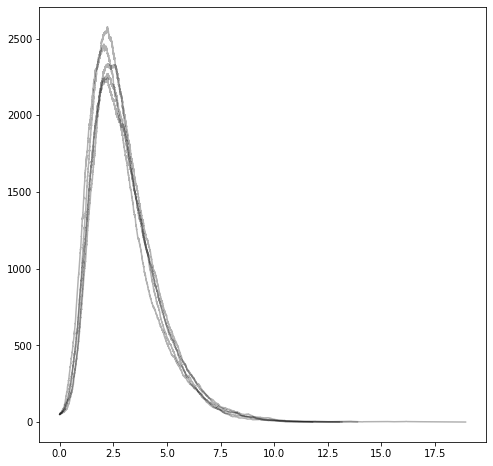

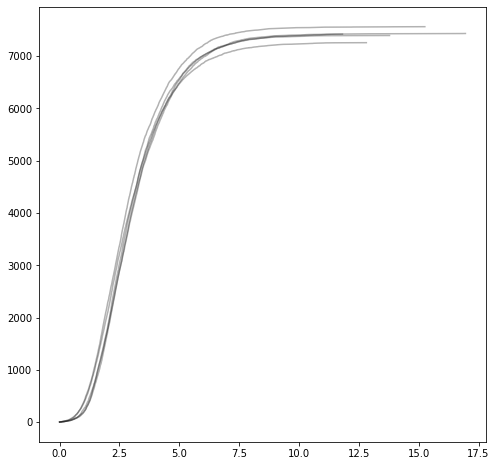

In [106]:
N = 10 ** 4
G = nx.barabasi_albert_graph(N, 8)

tmax = 20 
iterations = 5  #run 5 simulations
tau = 0.15        #transmission rate
gamma = 1.0    #recovery rate
rho = 0.005      #random fraction initially infected

ax1 = plot_vanilla_run(G, tau ,gamma, rho, 20, series='IR')
# ax1.set_xlabel("Time")
# ax1.set_ylabel("# Infected")
# ax1.set_title("Infections v time in the NO quarantine setting")
# 
# ax2 = plot_vanilla_run(G, tau, gamma, rho, 20, series='R')
# ax2.set_xlabel("Time")
# ax2.set_ylabel("# Recovered")
# ax2.set_title("# Recovered vs. Time in the NO quarantine setting")

In [107]:
qtimes = [_/2.0 for _ in range(11)]
data = data_getter(G, tau ,gamma, rho, tmax, qtimes)

running qs on series [0.0, 20.0]
running qs on series [0.5, 19.5]
running qs on series [1.0, 19.0]
running qs on series [1.5, 18.5]
running qs on series [2.0, 18.0]
running qs on series [2.5, 17.5]
running qs on series [3.0, 17.0]
running qs on series [3.5, 16.5]
running qs on series [4.0, 16.0]
running qs on series [4.5, 15.5]
running qs on series [5.0, 15.0]


Text(0.5, 1.0, 'Max#I/Final#R vs Time quarantine was applied')

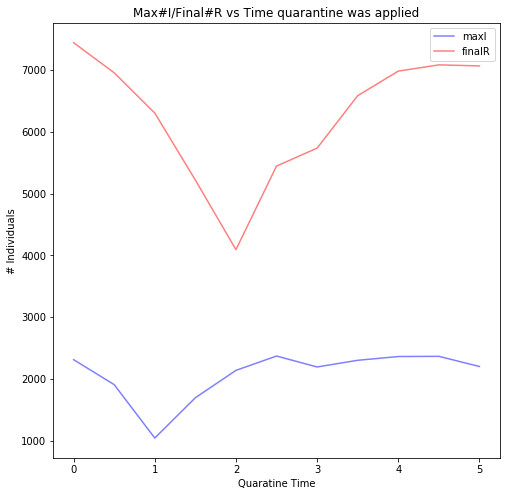

In [108]:
ax = plot_maxI_finalR(data, qtimes)
ax.set_title("Max#I/Final#R vs Time quarantine was applied")

Text(0.5, 1.0, 'Number of Recovered vs time in quarantine settings')

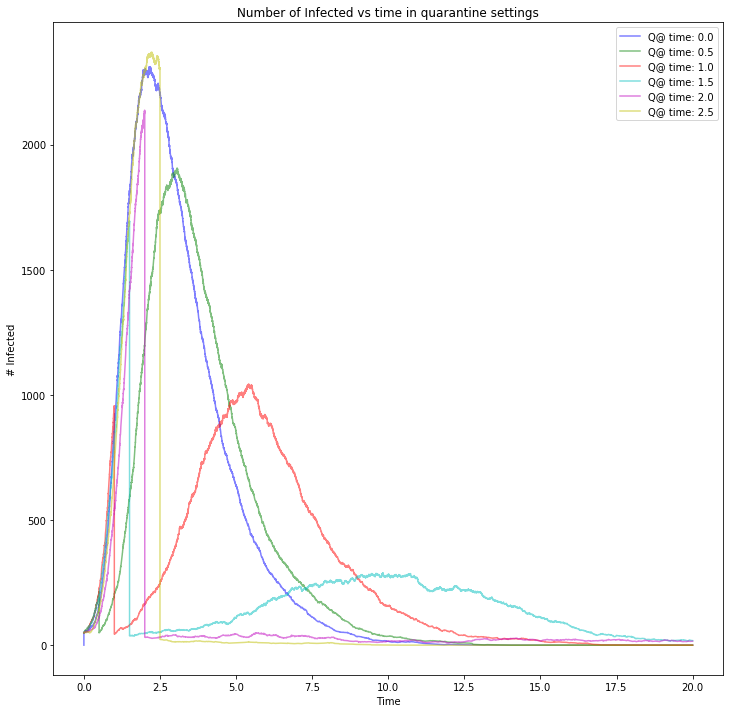

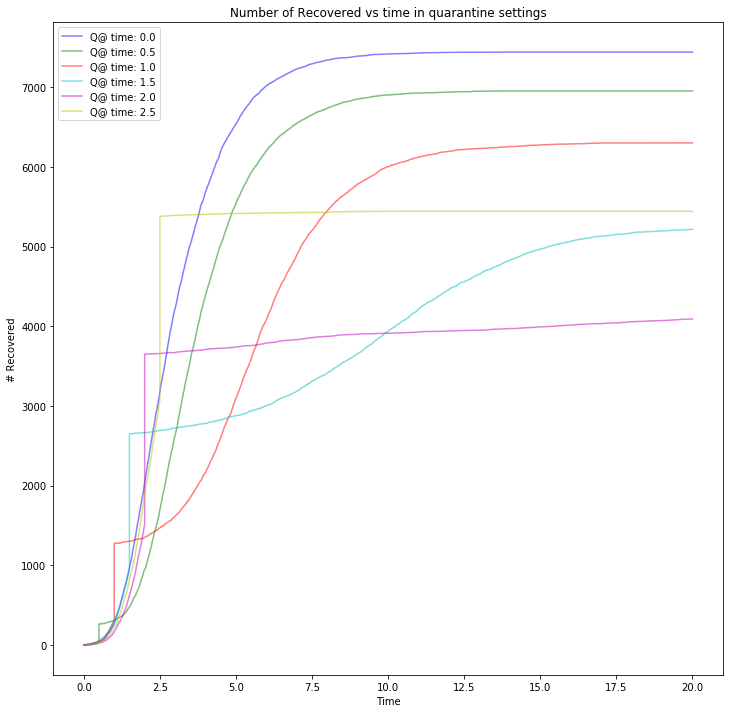

In [109]:
ax3 = plot_SIR_runs(data, qtimes, [0, 1, 2, 3, 4, 5], series='I')
ax3.set_xlabel('Time')
ax3.set_ylabel('# Infected')
ax3.set_title("Number of Infected vs time in quarantine settings")

ax4 = plot_SIR_runs(data, qtimes, [0, 1, 2, 3, 4, 5], series='R')
ax4.set_xlabel('Time')
ax4.set_ylabel('# Recovered')
ax4.set_title("Number of Recovered vs time in quarantine settings")



/home/matt/config/py3/lib/python3.6/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


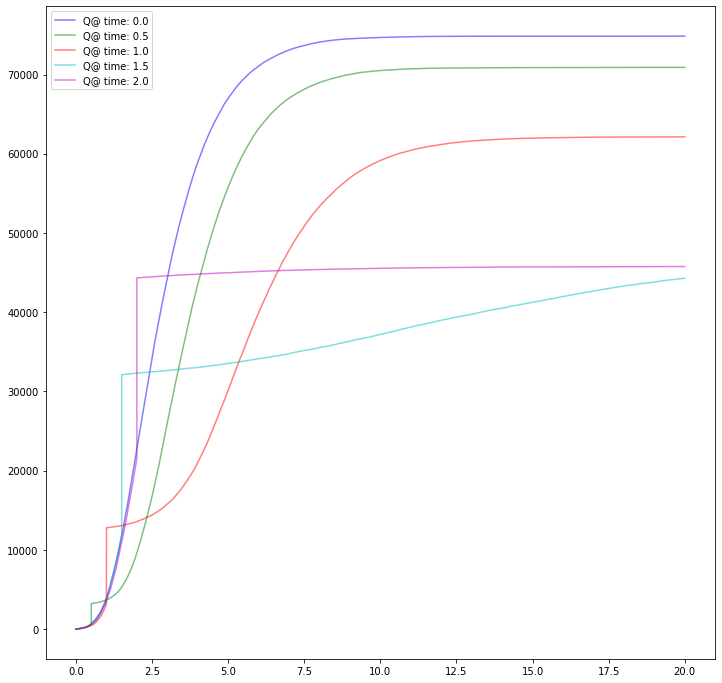

In [54]:
plot_SIR_runs(data, qtimes, [0, 1, 2, 3, 4], series='R')

In [110]:
# Try two quarantines:
dq = quarantine_cycle(G, tau, gamma, rho, [0.8, 2.0], 20)

running qs on series [0.8, 1.2, 18.0]


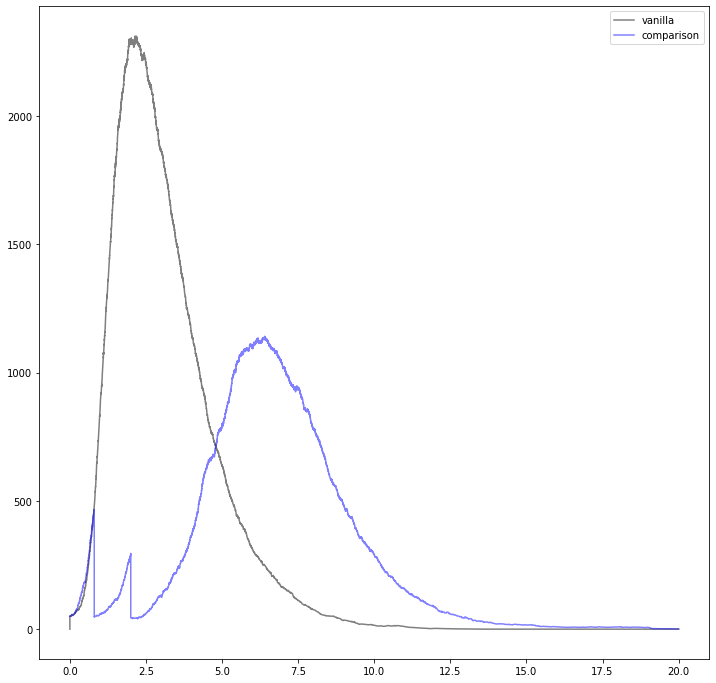

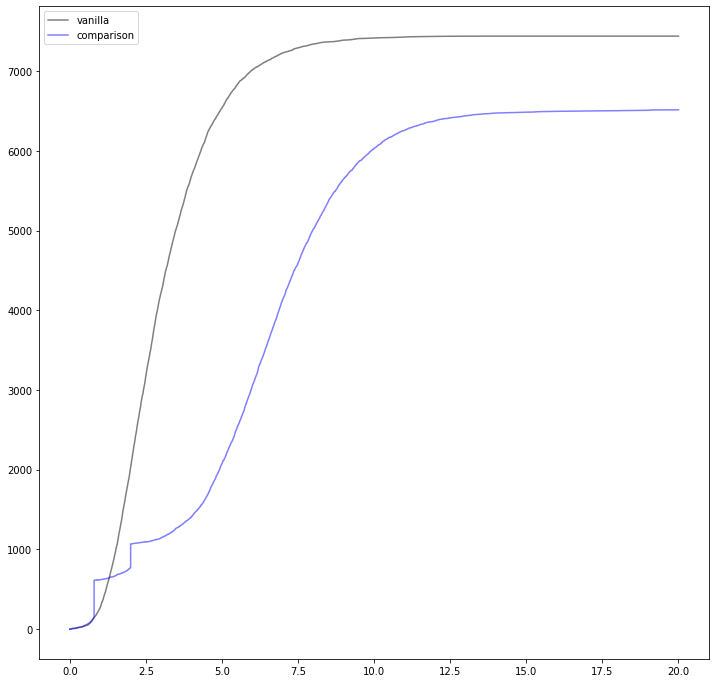

In [112]:
compare_to_vanilla(data[0], dq, 'I')
compare_to_vanilla(data[0], dq, 'R')

In [119]:
# Do double series: 
# Quarantine pairs are: time_to_first, time_to_second, final
# Do 100 pairs:
qpairs = [[i / 4.0, i / 4.0 + j / 4.0] for i in range(10) for j in range(10)]
grid_run =data_getter(G, tau, gamma, rho, 20, qpairs)

running qs on series [0.0, 0.0, 20.0]
running qs on series [0.0, 0.25, 19.75]
running qs on series [0.0, 0.5, 19.5]
running qs on series [0.0, 0.75, 19.25]
running qs on series [0.0, 1.0, 19.0]
running qs on series [0.0, 1.25, 18.75]
running qs on series [0.0, 1.5, 18.5]
running qs on series [0.0, 1.75, 18.25]
running qs on series [0.0, 2.0, 18.0]
running qs on series [0.0, 2.25, 17.75]
running qs on series [0.25, 0.0, 19.75]
running qs on series [0.25, 0.25, 19.5]
running qs on series [0.25, 0.5, 19.25]
running qs on series [0.25, 0.75, 19.0]
running qs on series [0.25, 1.0, 18.75]
running qs on series [0.25, 1.25, 18.5]
running qs on series [0.25, 1.5, 18.25]
running qs on series [0.25, 1.75, 18.0]
running qs on series [0.25, 2.0, 17.75]
running qs on series [0.25, 2.25, 17.5]
running qs on series [0.5, 0.0, 19.5]
running qs on series [0.5, 0.25, 19.25]
running qs on series [0.5, 0.5, 19.0]
running qs on series [0.5, 0.75, 18.75]
running qs on series [0.5, 1.0, 18.5]
running qs on se

In [131]:
# Stack into a 2d array:
empty_grid = [[None for _ in range(10)] for _ in range(10)]
for i, el in enumerate(grid_run):
    empty_grid[i % 10][i // 10] = el
max_i_grid = [[get_max_I(el) for el in row] for row in empty_grid]
last_r_grid = [[get_final_R(el) for el in row] for row in empty_grid]

Text(0.5, 15.0, 'Time after first quarantine before second quarantine')

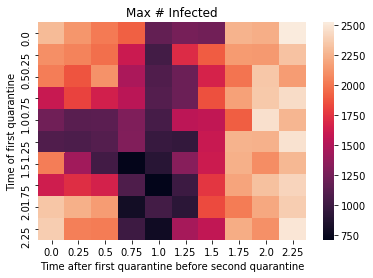

In [149]:
import seaborn as sns
ax = sns.heatmap(np.array(max_i_grid))
ax.set_yticklabels([_ / 4.0 for _ in range(10)])
ax.set_xticklabels([_ / 4.0 for _ in range(10)])
ax.set_title("Max # Infected")
ax.set_ylabel("Time of first quarantine")
ax.set_xlabel("Time after first quarantine before second quarantine")

Text(0.5, 15.0, 'Time after first quarantine before second quarantine')

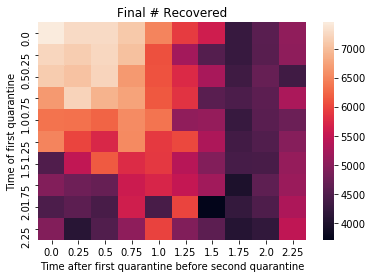

In [150]:
ax = sns.heatmap(np.array(last_r_grid))
ax.set_yticklabels([_ / 4.0 for _ in range(10)])
ax.set_xticklabels([_ / 4.0 for _ in range(10)])
ax.set_title("Final # Recovered")
ax.set_ylabel("Time of first quarantine")
ax.set_xlabel("Time after first quarantine before second quarantine")

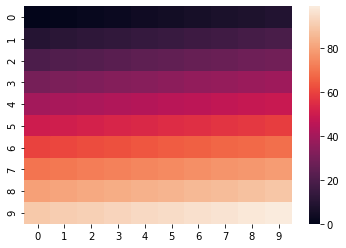

In [139]:
# HOW DOES SEABORN WORK 
range_grid = [[i + 10*j for i in range(10)] for j in range(10)]
sns.heatmap(np.array(range_grid))